<h1>Computer Vision Project</h1>
<h2>Phase 1</h2>
<h3>Team 3</h3>
<ul><li>Anas Salah</li>
<li> Alaa Hamdy </li>
<li>Ahmed Amr </li>
</ul>

<h3>Import libraries and packages used</h3>

In [3]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import imutils
import json
import statistics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
from torchvision import ops
from operator import itemgetter
from PIL import Image
import copy



c:\Python310\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),


<h3>Load training images</h3>

In [4]:
images = []
labels = []
true_boxes = []

picsFolder_path = "train/"
with open('digitStruct.json') as f:
    data = json.load(f)

# import colored pictures
for i in range(len(data)):
    image = cv2.imread(picsFolder_path + data[i]['filename'])
    images.append(image)
    temp=[]
    for j in range(len(data[i]['boxes'])):
        temp.append(data[i]['boxes'][j]['label'])
    temp = np.array(temp)
    labels.append(temp)
    true_boxes.append(data[i]['boxes'])

# for image in os.listdir(picsFolder_path):
#     images.append(image)
print("we have",len(images),"images")



we have 33402 images


<h2>Phase 1 algoritm </h2>

In [3]:
def finalModel(image):
    
    boxes = []

    #convert the image to greyscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    

    #increase the contrast
    cv2.convertScaleAbs(image, image)


    #apply gaussian blur to smooth the image
    image = cv2.GaussianBlur(image, (3, 3), 0)
    

    #apply adaptive threshholding
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)


    #apply canny edge detection
    image = cv2.Canny(image, 150, 200, 255)
   


    #find contours in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    
    #get the center of the image
    h, w = image.shape
    center = (int(w/2), int(h/2))

    #calculate the bounding rectangle of each contour and add it to a dictionary, only if it's near the center
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        if abs((x + w/2) - center[0]) < 1.5*w and abs((y + h/2) - center[1]) < 1.5*h:
            boxes.append({'left': x, 'top': y, 'width': w, 'height': h})


    return boxes


<h3>Accuracy functions for phase 1</h3>

In [4]:
def box_iou(boxA, boxB):
    # Calculate the intersection coordinates of the two bounding boxes
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Compute the area of both bounding boxes
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Compute the union area
    union_area = boxA_area + boxB_area - intersection_area
    
    # Compute the IOU
    iou = intersection_area / union_area
    
    return iou

# # the original version of iouPicTest
#
# def iouPicTest(truth, predicted, threshold1=0.5):
#     ious = []
#     for i in range(len(truth)):
#         for j in range(len(predicted)):
#             truth_box = [truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'], truth[i]['top']+truth[i]['height']]
#             predicted_box = [predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'], predicted[j]['top']+predicted[j]['height']]
#             iou = box_iou(truth_box, predicted_box)
#             if iou >= threshold1:
#                 ious.append(iou)
#     acc = np.average(ious) if ious else 0
#     return acc

#this updated version of iouPicTest returns the accuracy same as before but with an added returned list of the accurate boxes for phase 1 (ie. the boxes that actually contains digits)
#phase 2 could work on either functions but the older version will take too much time trying to detect digits in boxes that are not true(do not contain digits)
def iouPicTest(truth, predicted, threshold1=0.5):
    ious = []
    accurate_boxes = []
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = [truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'], truth[i]['top']+truth[i]['height']]
            predicted_box = [predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'], predicted[j]['top']+predicted[j]['height']]
            iou = box_iou(truth_box, predicted_box)
            if iou >= threshold1:
                ious.append(iou)
                accurate_boxes.append({'top': predicted_box[1], 'left': predicted_box[0], 'height': predicted_box[3] - predicted_box[1], 'width': predicted_box[2] - predicted_box[0], 'label': truth[i]['label']})
    acc = np.average(ious) if ious else 0
    return acc, accurate_boxes


<h3>sample image displaying it 3 times: original image, phase1 result,phase1 result with accurate boxes only</h3>

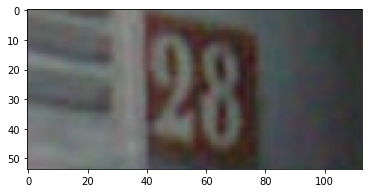

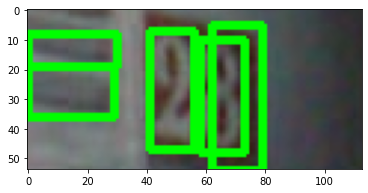

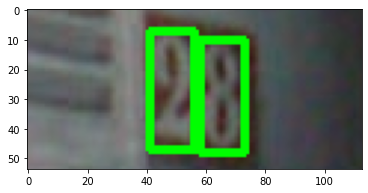

In [5]:

i = 1005
plt.imshow(images[i])
plt.show()
image = images[i].copy()
image2 = images[i].copy()

predicted_boxes = finalModel(image)
acc, new_boxes =(iouPicTest(true_boxes[i],predicted_boxes))
acc_boxes= true_boxes[i]
# print(acc_boxes)
# print(new_boxes)
for i in predicted_boxes:
    cv2.rectangle(image, (i['left'], i['top']), (i['left'] +
                    i['width'], i['top']+i['height']), (0, 255, 0), 2)
plt.imshow(image)
plt.show()
for i in new_boxes:
    cv2.rectangle(image2, (i['left'], i['top']), (i['left'] +
                    i['width'], i['top']+i['height']), (0, 255, 0), 2)

plt.imshow(image2)
plt.show()



<h3>import the templates into a disctionary</h3>

In [5]:
#the dictionary will contain the digits as keys and each value is a list of template images of that digit(key)

# Create an empty dictionary to store the images
templates_dict = {}

# Loop through the folders in the 'temps' directory
for num_folder in os.listdir('temps'):

    # If the folder name is a number (i.e. 0-9), proceed
    if num_folder.isdigit():

        # Create an empty list to store the images for this number
        num_images = []
        # Loop through the images in this folder
        for image_file in os.listdir(f'temps/{num_folder}'):
            # Load the image using OpenCV
            image = cv2.imread(f'temps/{num_folder}/{image_file}')


            # Append the image to the list for this number
            num_images.append(image)
            image_temp = cv2.bitwise_not(image)

            num_images.append(image_temp)

        # Add the list of images to the dictionary, with the number as the key
        templates_dict[num_folder] = num_images


<h3>Phase 2 algorithm</h3>

In [7]:
# this function will take the image,it's (accurate phase1)boxes and the templates dictionary and should return the number of correctly identified boxes

def identify_numbers(img, accurate_boxes, templates_dict, threshold=0.5):
    
    accuracy = 0
    
    # if phase1 returned no correct boxes or no boxes at all
    if len(accurate_boxes) == 0:
        # print("no boxes were generated")
        return 0
    
    # loop over each box
    for box in accurate_boxes:


        # Extract the image patch corresponding to this box(the box is just coordinates(x,y,w,h) in the image, so it needs to be converted to an image to compare)
        img_patch = img[box['top']:box['top']+box['height'], box['left']:box['left']+box['width']]

        if img_patch.shape[0] == 0 or img_patch.shape[1] == 0:
            # print("Box has no height or width")
            accuracy += 1
            continue
        # Max val is to find the maximum match between the box and the templates and the best_digit is to store the label of that template (simple max in an array method)
        max_val = -1
        best_digit = None

        # Loop through the templates for each digit and compare with hit and miss
        for digit, templates in templates_dict.items():

            for template in templates:

                # Check dimensions of image patch and template and resize the larger one to match the smaller one
                if img_patch.shape[0] > template.shape[0] or img_patch.shape[1] > template.shape[1]:
                    resized_img_patch = cv2.resize(img_patch, (template.shape[1], template.shape[0]))
                    resized_template = template
                else:
                    resized_img_patch = img_patch
                    resized_template = cv2.resize(template, (img_patch.shape[1], img_patch.shape[0]))
                
                # convert both images to binary (black and white) using adaptive thresholding
                resized_img_patch = cv2.cvtColor(resized_img_patch, cv2.COLOR_BGR2GRAY)
                resized_img_patch = cv2.adaptiveThreshold(resized_img_patch, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
                resized_template = cv2.cvtColor(resized_template, cv2.COLOR_BGR2GRAY)
                resized_template = cv2.adaptiveThreshold(resized_template, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

                # count the white (1) pixels in the box image
                count_bb = cv2.countNonZero(resized_img_patch)

                # And both images
                res = cv2.bitwise_and(resized_img_patch, resized_template)

                # count the number of white (1) pixels resulted from that anding
                count = cv2.countNonZero(res)

                # get the max ratio of coorect pixels from all templates (simple max in an array method)
                if  (count/count_bb) > max_val:
                    max_val = count/count_bb
                    best_digit = digit

        
        # Print the identified digit with the highest match score and draw a rectangle on the image
        if best_digit is not None:
            actual_digit = str(int(box['label']))
            
            # if the identified digit is correct
            if best_digit == actual_digit :
                accuracy += 1   
                digit_rect = (box['left'], box['top'], box['width'], box['height'])
                cv2.rectangle(img, (digit_rect[0], digit_rect[1]), (digit_rect[0] + digit_rect[2], digit_rect[1] + digit_rect[3]), (0, 0, 255), 2)
                cv2.putText(img, best_digit, (digit_rect[0], digit_rect[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)




    return accuracy





<h3>Phase 2 testing</h3>

In [13]:

total_acc = []

# 1000 images take approx 3 mins, hence the whole data set is projected to take 1 hr 30 min
# accuracy for first 1000 images is ~36%, accuracy is normally betwween 30-45 % depending on the quality of images selected

# for i in range (0,len(images)):
for i in range(1,2):

    image = images[i]
 
    img = copy.copy(image)


    bounding_boxes = (finalModel(img))
    acc, new_boxes =(iouPicTest(true_boxes[i],bounding_boxes))

    acc = identify_numbers(img,new_boxes,templates_dict)
    acc = acc/len(true_boxes[i])
    total_acc.append(acc)

print(np.average(total_acc)*100)

[{'top': 31, 'left': 74, 'height': 26, 'width': 24, 'label': 2.0}, {'top': 27, 'left': 100, 'height': 30, 'width': 21, 'label': 3.0}, {'top': 27, 'left': 100, 'height': 30, 'width': 21, 'label': 3.0}]
[{'top': 29, 'left': 77, 'height': 32, 'width': 23, 'label': 2}, {'top': 25, 'left': 98, 'height': 32, 'width': 26, 'label': 3}]
50.0


In [8]:
# Testing on the true boxes from the digiStruct file

total_acc = []

# 1000 images take approx 3 mins, hence the whole data set is projected to take 1 hr 30 min
# accuracy for first 1000 images is ~36%, accuracy is normally betwween 30-45 % depending on the quality of images selected

# for i in range (0,len(images)):
for i in range(0,1000):

    image = images[i]
 
    img = copy.copy(image)


    # Parse the true boxes from the digiStruct file
    new_list = [{key: int(inner_dict[key]) for key in ['top', 'left', 'height', 'width', 'label']} for inner_dict in true_boxes[i]]

    acc = identify_numbers(img,new_list,templates_dict)
    acc = acc/len(true_boxes[i])
    total_acc.append(acc)

print(np.average(total_acc)*100)

35.483333333333334
